<a href="https://colab.research.google.com/github/zszazi/awesome-collection-of-google-colab-notebooks/blob/master/segmentation_with_CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Segmentation with CamVid using Fastai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [6]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

# Data

In [11]:
fnames = get_image_files(path_img)
fnames[6:9]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_007290.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00510.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01740.png')]

In [12]:
lbl_names = get_image_files(path_lbl)
lbl_names[6:9]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01920_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08400_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01110_P.png')]

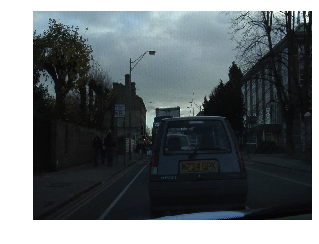

In [13]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
#create a lambda function for matching the labels and image file names
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'


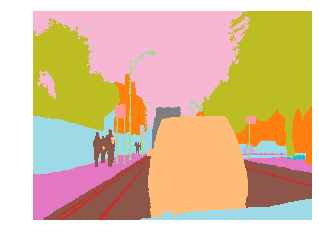

In [15]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)


All the above where already present in the dataset

In [16]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

The above images are coded pixel wise for what could be the object in context


In [17]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [22]:
codes[21]

'Sky'

In [23]:

codes[19]

'Sidewalk'

So in the above tensor we observe that 21 = 'Sky' and 19 = 'Sidewalk', and this is done for all pixel and are color coded at the end for segmentation

# Dataset

In [24]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


As we have 16 GB RAM so we can have BS =  8 else have BS = 4(in case of 8 GB RAM) and another method to overcome this is by using **Mixed Precision Training** ie using 16 bit or lower bit floating point calculation instead of default 32 bit training using the function **to_fp16** at end of our learner

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

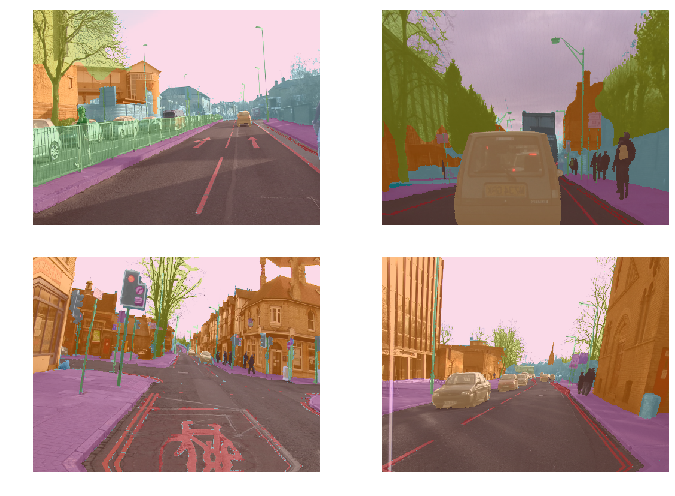

In [27]:
data.show_batch(2, figsize=(10,7))

# Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Above function calculates accuracy, as we need to also take care of Void coded in the segment image so we write a custom accurac function

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [44]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


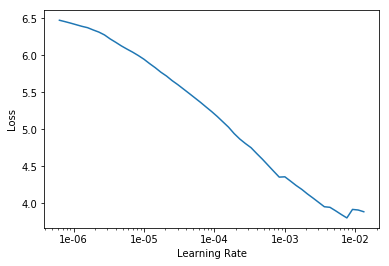

In [45]:
learn.recorder.plot()


Select suitable learning rate on observing the plot

In [0]:
lr=3e-3

In [48]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.059052,0.913351,0.755297,01:39
1,0.802634,0.675157,0.837658,01:35
2,0.702067,0.544527,0.858812,01:35
3,0.659105,0.530888,0.860856,01:35
4,0.642818,0.696398,0.822780,01:34
5,0.632723,0.463703,0.869371,01:34
6,0.593742,0.543366,0.870448,01:34
7,0.576052,0.562720,0.864755,01:33
8,0.517319,0.494092,0.869977,01:33
9,0.460299,0.357173,0.897926,01:32


In [52]:
learn.save('stage-1',return_path=True)

PosixPath('/root/.fastai/data/camvid/images/models/stage-1.pth')

In [0]:
learn.load('stage-1')

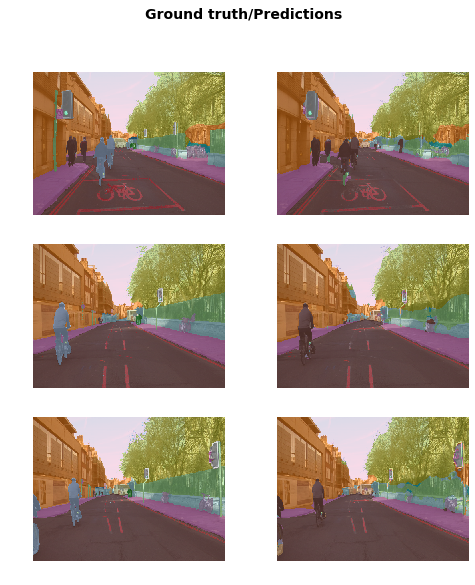

In [54]:
learn.show_results(rows=3, figsize=(8,9))